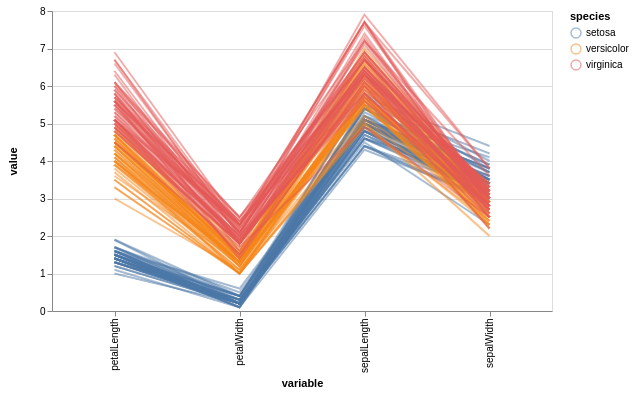

In [4]:
import altair as alt
from vega_datasets import data

source = data.iris()
source_transformed = source.reset_index().melt(['species', 'index'])

alt.Chart(source_transformed).mark_line().encode(
    x='variable:N',
    y='value:Q',
    color='species:N',
    detail='index:N',
    opacity=alt.value(0.5)
).properties(width=500)

In [1]:
from neptunelib.session import Session
from neptunecontrib.api.utils import strip_prefices

session = Session()
project = session.get_projects('neptune-ml')['neptune-ml/Home-Credit-Default-Risk']
leaderboard = project.get_leaderboard(state=['succeeded'], owner=['czakon'])
leaderboard.head()

hyper_df = leaderboard[['channel_ROC_AUC',
                        'parameter_lgbm__max_depth',
                        'parameter_lgbm__num_leaves',
                        'parameter_lgbm__min_child_samples']]
hyper_df.columns = strip_prefices(hyper_df.columns, prefices=['channel_','parameter_'])
hyper_df.head()

,ROC_AUC,lgbm__max_depth,lgbm__num_leaves,lgbm__min_child_samples
0,0.7578376974936794,20.0,50.0,20.0
1,0.7578376974936794,20.0,50.0,20.0
2,0.7578376974936794,20.0,50.0,20.0
3,0.7383150842338956,20.0,50.0,20.0
4,0.7859497222152486,-1.0,100.0,600.0


In [12]:
import pandas as pd

def format_df(df, metric_column, param_columns):
    df = pd.melt(df, 
                 id_vars=metric_column, 
                 value_vars=param_columns,
                 var_name='parameters',
                 value_name='parameter_value')
    return df

In [25]:
METRIC_COLUMN = 'ROC_AUC'
PARAMETER_COLUMNS = ['lgbm__max_depth', 'lgbm__num_leaves', 'lgbm__min_child_samples']

  lgbm__max_depth         ...                     ROC_AUC
0            20.0         ...          0.7578376974936794
1            20.0         ...          0.7578376974936794
2            20.0         ...          0.7578376974936794
3            20.0         ...          0.7383150842338956
4            -1.0         ...          0.7859497222152486

[5 rows x 4 columns]


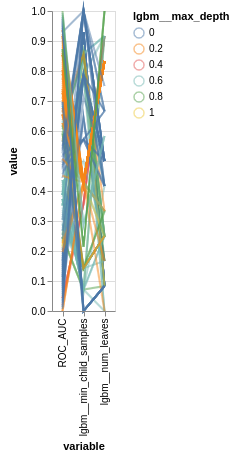

In [28]:
import numpy as np

def parallel_coordinates(df, metric_column, parameter_columns):
    df = df[parameter_columns+[metric_column]]
    print(df.head())
    df2 = df.copy()
    labs = {}
    for col, dfcol in df.items():
        if dfcol.dtype == np.object:
            dfcol = dfcol.astype('category')
        if isinstance(dfcol.dtype, pd.core.dtypes.dtypes.CategoricalDtype):
            y = dfcol.cat.codes
            xlabs = dfcol.cat.categories.values
            xnorm = np.linspace(0,1,len(dfcol.cat.categories))
        else:
            y = dfcol
            nticks = 11
            if dfcol.dtype == np.int64:
                ndec = 0
                nticks = min(nticks, len(dfcol.unique()))
            else:
                ndec = 1
            if nticks < 11:
                xorig = list(sorted(dfcol.unique()))
                xnorm = [(x - y.min())/(y.max() - y.min()) for x in xorig] 
            else:
                xnorm = np.linspace(0,1,nticks)
                xorig = [(x*(y.max() - y.min())+y.min()) for x in xnorm] 
            xlabs = [f'{x:.{ndec}f}' for x in xorig]
        labs[col] = pd.Series(xlabs, index=xnorm)
        df2[col] = (y - y.min())/(y.max() - y.min())


    vcolor = 'lgbm__max_depth'
    color_spec = '' if df[vcolor].dtype in [np.float64,np.int64] else ':N'
    df2melt = df2.reset_index().melt(['index',vcolor])
    dfvcolor = df2melt[df2melt.variable==df2.columns[0]].copy()
    dfvcolor['value'] = dfvcolor[vcolor]
    dfvcolor['variable'] = vcolor
    df2melt = pd.concat([df2melt,dfvcolor], ignore_index=True)

    pcplot = alt.Chart(df2melt).mark_line().encode(
        x='variable:N',
        y='value:Q',
        detail='index',
        color=vcolor+color_spec,
        opacity=alt.value(0.5)
    )
    for v in list(sorted(df2melt['variable'].unique())):
        dflab = labs[v].reset_index()
        if dflab.shape[0]>11:
            continue
        dflab.columns = ['value','lab']
        dflab['variable'] = v
        pcplot += alt.Chart(dflab).mark_text(
            align='center',
            baseline='middle',
        ).encode(
            x='variable',
            y='value',
            text='lab'
        )
    return pcplot
                        
parallel_coordinates(hyper_df, metric_column=METRIC_COLUMN, parameter_columns=PARAMETER_COLUMNS)